In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, root_mean_squared_error

color_pal = sns.color_palette()


In [143]:
df = pd.read_csv("Energy_data\PJME_hourly.csv", index_col = [0], parse_dates = [0])

In [7]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


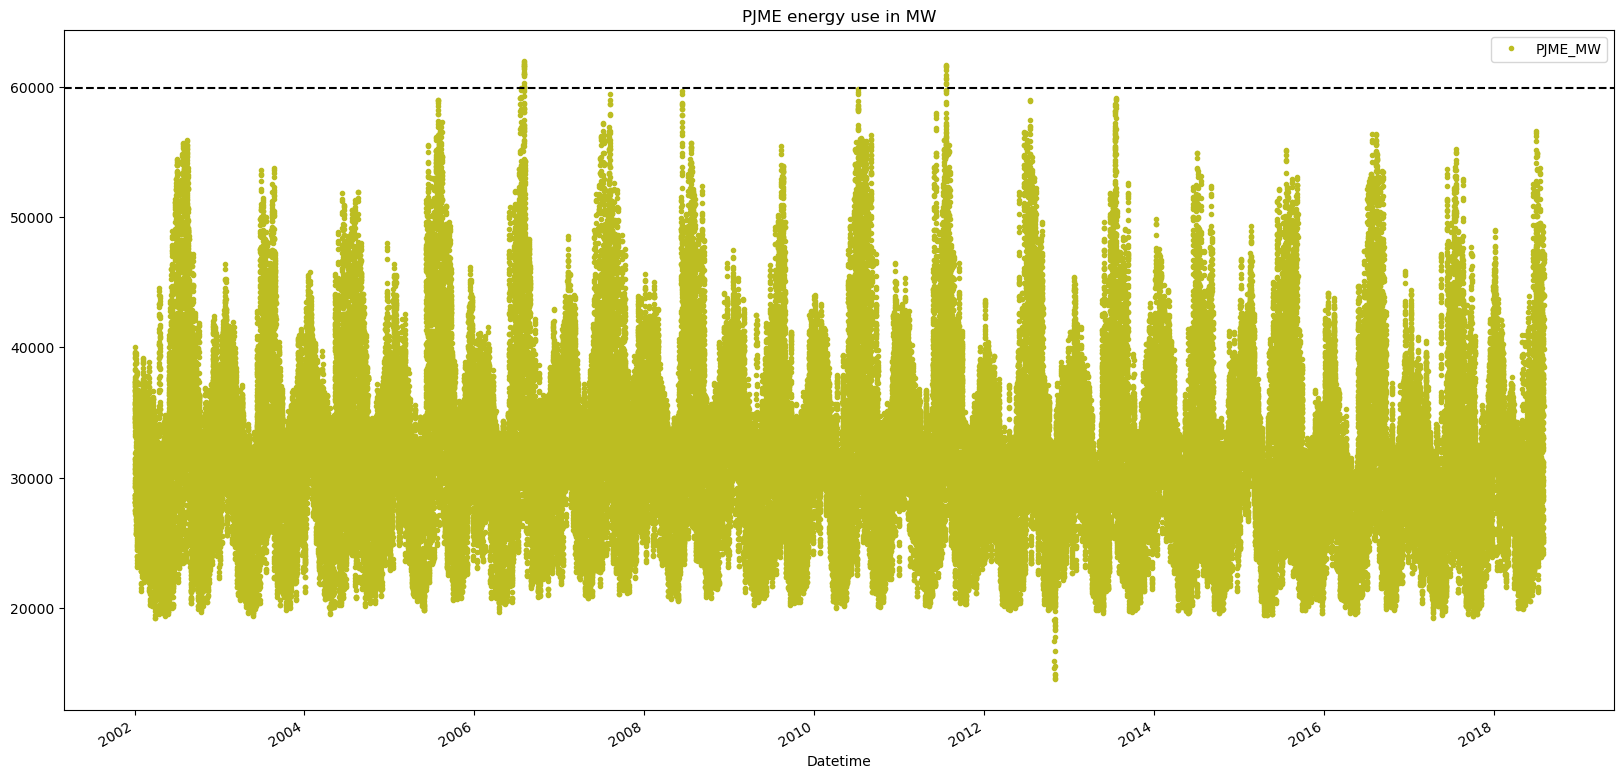

In [98]:
df.plot(style = '.', 
        figsize=(20,10), 
        color = color_pal[8],
       title = 'PJME energy use in MW'
       )
plt.axhline(Q3 + IQR * 3, color = 'black', ls = '--')

# Outlier removal (IQR messing around)

<Axes: ylabel='Frequency'>

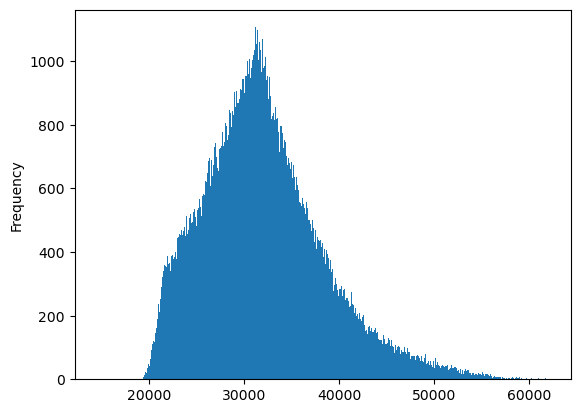

In [12]:
df['PJME_MW'].plot(kind = 'hist', bins = 500)

In [24]:
Q1 = df.PJME_MW.quantile(0.25)
Q3 = df.PJME_MW.quantile(0.75)
IQR = Q3 - Q1

In [50]:
df[(df.PJME_MW < Q1 - IQR * 1.5)] #.sort_index().plot()

,PJME_MW
Datetime,
2012-10-30 01:00:00,15390.0
2012-10-30 02:00:00,14955.0
2012-10-30 03:00:00,14586.0
2012-10-30 04:00:00,14544.0
2012-10-30 05:00:00,14821.0


<Axes: xlabel='Datetime'>

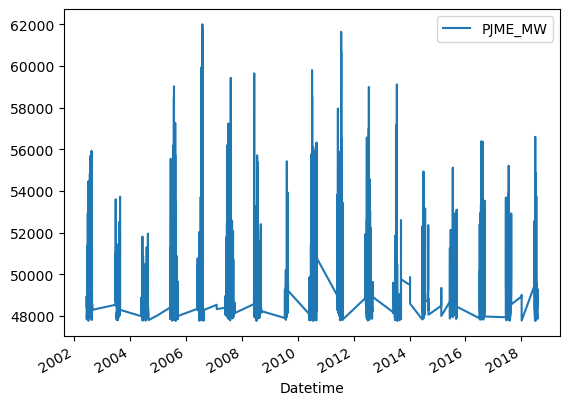

In [42]:
df[(df.PJME_MW > Q3 + IQR * 1.5)].sort_index().plot()

In [80]:
Q3 + IQR * 2

51804.0

<Axes: xlabel='Datetime'>

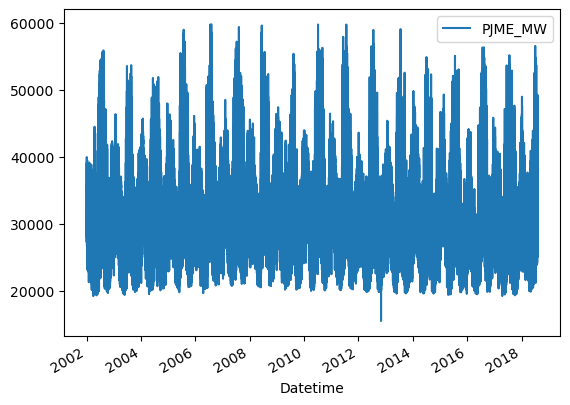

In [100]:
df_iqr = df[(df.PJME_MW >= Q1 - IQR * 1.5) & (df.PJME_MW <= Q3 + IQR * 3)]
df_iqr.sort_index().plot()

<Axes: ylabel='Frequency'>

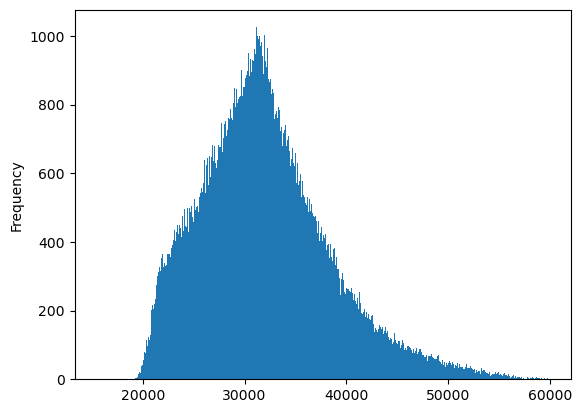

In [102]:
df_iqr['PJME_MW'].plot(kind = 'hist', bins = 500)

# Outlier removal (video)

<Axes: xlabel='Datetime'>

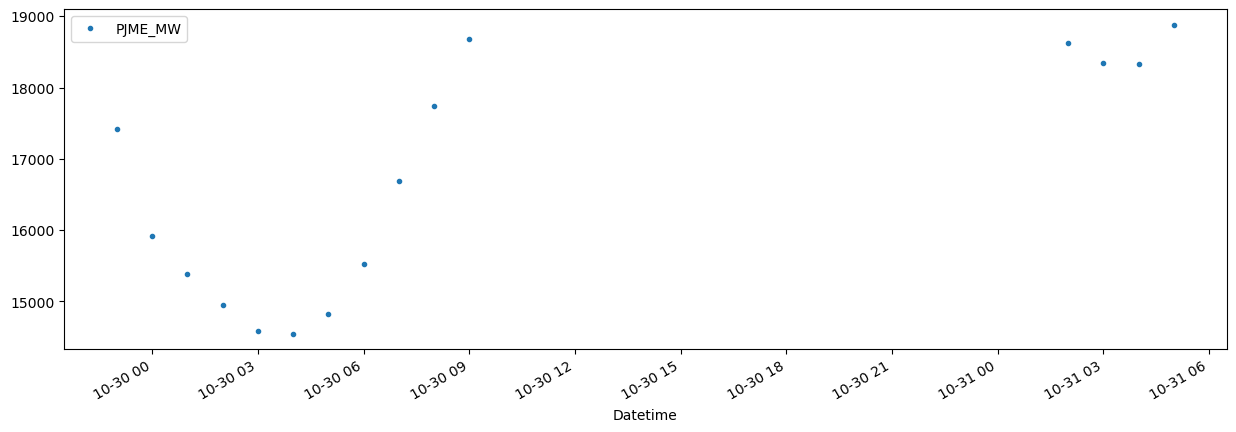

In [116]:
df.query('PJME_MW < 19000').plot(figsize=(15,5), style = '.')

In [145]:
df = df.query('PJME_MW > 19000').copy()

# Cross validation

In [147]:
from sklearn.model_selection import TimeSeriesSplit

In [149]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365, gap = 24)
df = df.sort_index()

train_idx : [     0      1      2 ... 101524 101525 101526], test_idx: [101551 101552 101553 ... 110308 110309 110310]
train_idx : [     0      1      2 ... 110284 110285 110286], test_idx: [110311 110312 110313 ... 119068 119069 119070]
train_idx : [     0      1      2 ... 119044 119045 119046], test_idx: [119071 119072 119073 ... 127828 127829 127830]
train_idx : [     0      1      2 ... 127804 127805 127806], test_idx: [127831 127832 127833 ... 136588 136589 136590]
train_idx : [     0      1      2 ... 136564 136565 136566], test_idx: [136591 136592 136593 ... 145348 145349 145350]


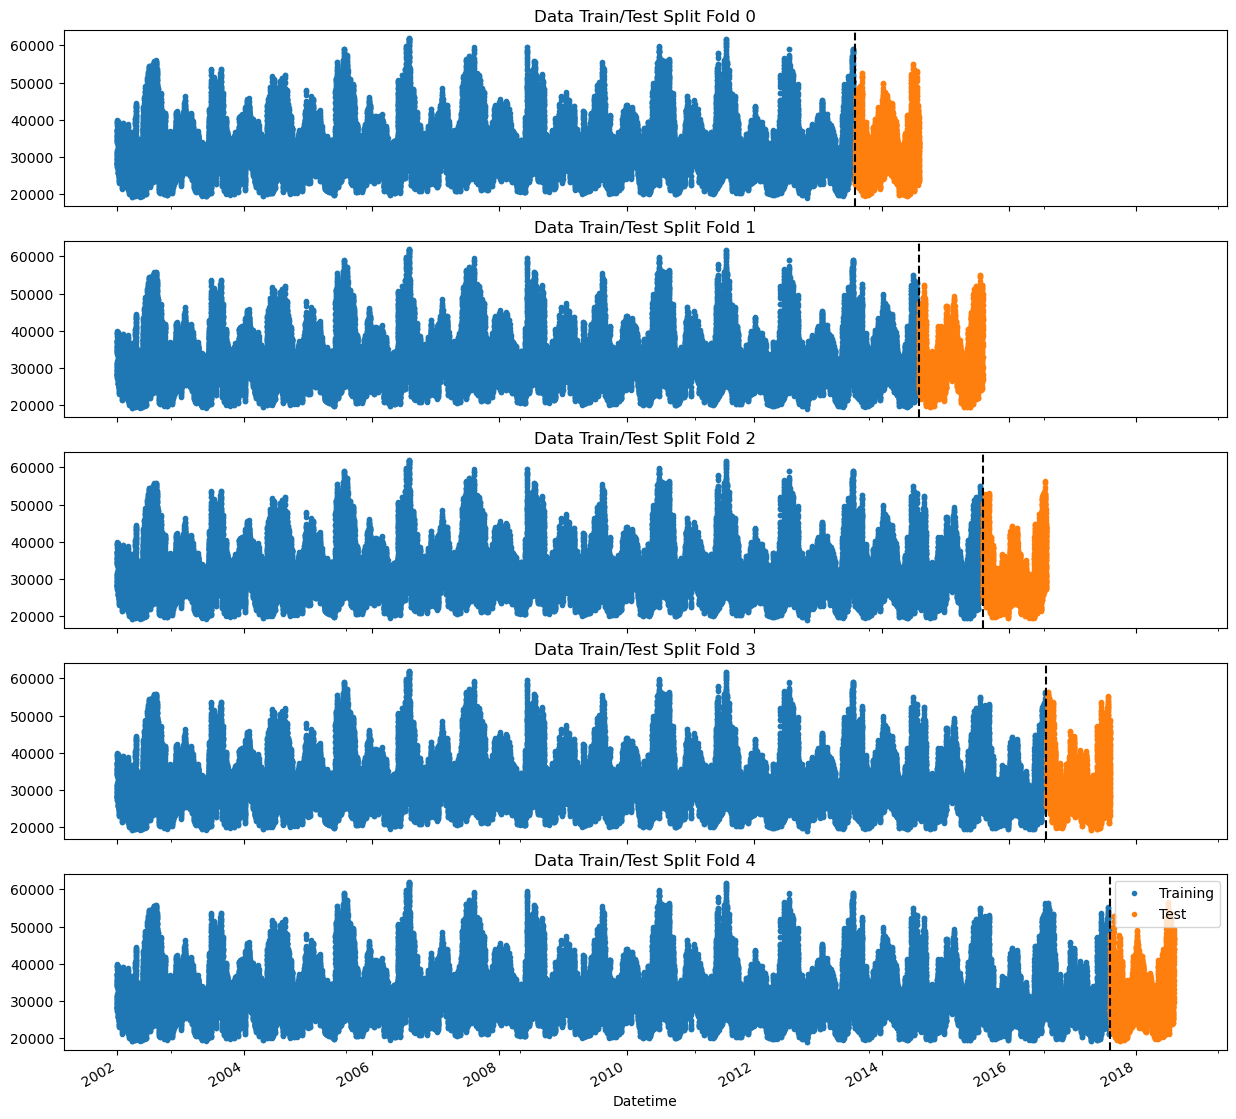

In [229]:
fig, axs = plt.subplots(5,1,figsize=(15,15),
                      sharex = True
                       )

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax = axs[fold],
                          style = '.', 
                           title = f'Data Train/Test Split Fold {fold}'
       )
    test['PJME_MW'].plot(ax = axs[fold],
                          style = '.', 
       )    
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold+=1
    plt.legend(['Training', 'Test'])
    print(f"train_idx : {train_idx}, test_idx: {val_idx}")

# Forecasting Horizon

In [245]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)


    #df['year'] = df.index.year
    return df

In [188]:
target_map = df['PJME_MW'].to_dict()

In [192]:
target_map


{Timestamp('2002-01-01 01:00:00'): 30393.0,
 Timestamp('2002-01-01 02:00:00'): 29265.0,
 Timestamp('2002-01-01 03:00:00'): 28357.0,
 Timestamp('2002-01-01 04:00:00'): 27899.0,
 Timestamp('2002-01-01 05:00:00'): 28057.0,
 Timestamp('2002-01-01 06:00:00'): 28654.0,
 Timestamp('2002-01-01 07:00:00'): 29308.0,
 Timestamp('2002-01-01 08:00:00'): 29595.0,
 Timestamp('2002-01-01 09:00:00'): 29943.0,
 Timestamp('2002-01-01 10:00:00'): 30692.0,
 Timestamp('2002-01-01 11:00:00'): 31395.0,
 Timestamp('2002-01-01 12:00:00'): 31496.0,
 Timestamp('2002-01-01 13:00:00'): 31031.0,
 Timestamp('2002-01-01 14:00:00'): 30360.0,
 Timestamp('2002-01-01 15:00:00'): 29798.0,
 Timestamp('2002-01-01 16:00:00'): 29720.0,
 Timestamp('2002-01-01 17:00:00'): 31271.0,
 Timestamp('2002-01-01 18:00:00'): 35103.0,
 Timestamp('2002-01-01 19:00:00'): 35732.0,
 Timestamp('2002-01-01 20:00:00'): 35639.0,
 Timestamp('2002-01-01 21:00:00'): 35285.0,
 Timestamp('2002-01-01 22:00:00'): 34007.0,
 Timestamp('2002-01-01 23:00:00'

In [198]:
df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) #Same day, last year,on the same week

In [210]:
#df['lag1.1'] = df['PJME_MW'].shift(364*24) # wouldve worked as well, i guess the above is more robust (if one hour is missing for ex)

In [208]:
df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)

In [212]:
def add_lags(df):
    df = df.copy()
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [214]:
df = add_lags(df)

Training with Cross Val

In [299]:
preds = []
scores = []
fold  = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['lag1', 'lag2', 'lag3', 'hour', 'dayofweek', 'quarter',
       'month', 'dayofyear', 'dayofmonth', 'weekofyear']
    TARGET = ['PJME_MW']
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    '''
    model = xgb.XGBRegressor(
        base_score = 0.5,
        n_estimators = 1000,
        booster = 'gbtree',
        early_stopping_rounds = 50,
        objective = 'reg:linear',
        max_depth = 3,
        learning_rate = 0.01)
        '''

    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=5000,          # large + early stopping chooses best
        early_stopping_rounds = 50,
        max_depth=3,
        min_child_weight=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,              # L1
        reg_lambda=1.0,             # L2
        gamma=0.0,                  # min split loss
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )
    
    model.fit(X_train, y_train,
             eval_set = [(X_train, y_train), (X_test, y_test)],
              verbose = 100
             )
    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = root_mean_squared_error(y_test, y_pred)
    scores.append(score)

[0]	validation_0-rmse:5492.82334	validation_1-rmse:5181.94259
[58]	validation_0-rmse:3081.40950	validation_1-rmse:3812.49717
[0]	validation_0-rmse:5478.89748	validation_1-rmse:5248.65700
[100]	validation_0-rmse:2988.70380	validation_1-rmse:3509.50939
[0]	validation_0-rmse:5469.17195	validation_1-rmse:5651.02679
[100]	validation_0-rmse:3028.82313	validation_1-rmse:3420.69299
[200]	validation_0-rmse:2853.61808	validation_1-rmse:3384.22329
[237]	validation_0-rmse:2808.36030	validation_1-rmse:3401.80961
[0]	validation_0-rmse:5479.13738	validation_1-rmse:5806.91921
[100]	validation_0-rmse:3045.60931	validation_1-rmse:3924.81512
[200]	validation_0-rmse:2886.43078	validation_1-rmse:3874.68762
[295]	validation_0-rmse:2783.22716	validation_1-rmse:3850.94405
[0]	validation_0-rmse:5502.53119	validation_1-rmse:5146.46709
[55]	validation_0-rmse:3214.24351	validation_1-rmse:3963.58291


1. Feature engineering is extremely essential. Make sure to get the right features before training your data. 

2. Instead of using base features try using derived ones such as "mean, median, std, var, rolling mean, rolling std, rolling median etc."

3. Use preprocessing to clean your data and make sure to interpolate your missing values instead of dropping them. 

4. Never mix things. Forcast trends with trends and linear with linear.

In [301]:
print(f'average of scores: {np.mean(scores):0.2f}')
print(scores)

average of scores: 3679.04
[3790.28662109375, 3491.853271484375, 3380.3359375, 3842.704833984375, 3890.0302734375]


In [305]:
df = create_features(df)

X_all = df[FEATURES]
y_all = df[TARGET]

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,          #Average of when model started to overfit
    early_stopping_rounds = 20,
    max_depth=3,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,              # L1
    reg_lambda=1.0,             # L2
    gamma=0.0,                  # min split loss
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

model.fit(X_all, y_all,
         eval_set = [(X_all, y_all)],
          verbose = 100
         )

[0]	validation_0-rmse:5491.86458
[100]	validation_0-rmse:3148.99329
[199]	validation_0-rmse:2992.78936


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,None


In [335]:
future = pd.date_range('2018-08-03', '2019-08-01', freq = '1h')
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, create_features(future_df)])

In [337]:
df_and_future = add_lags(df_and_future)

In [339]:
future_w_features = df_and_future.query('isFuture').copy()

In [343]:
future_w_features['predictions'] = model.predict(future_w_features[FEATURES])

<Axes: >

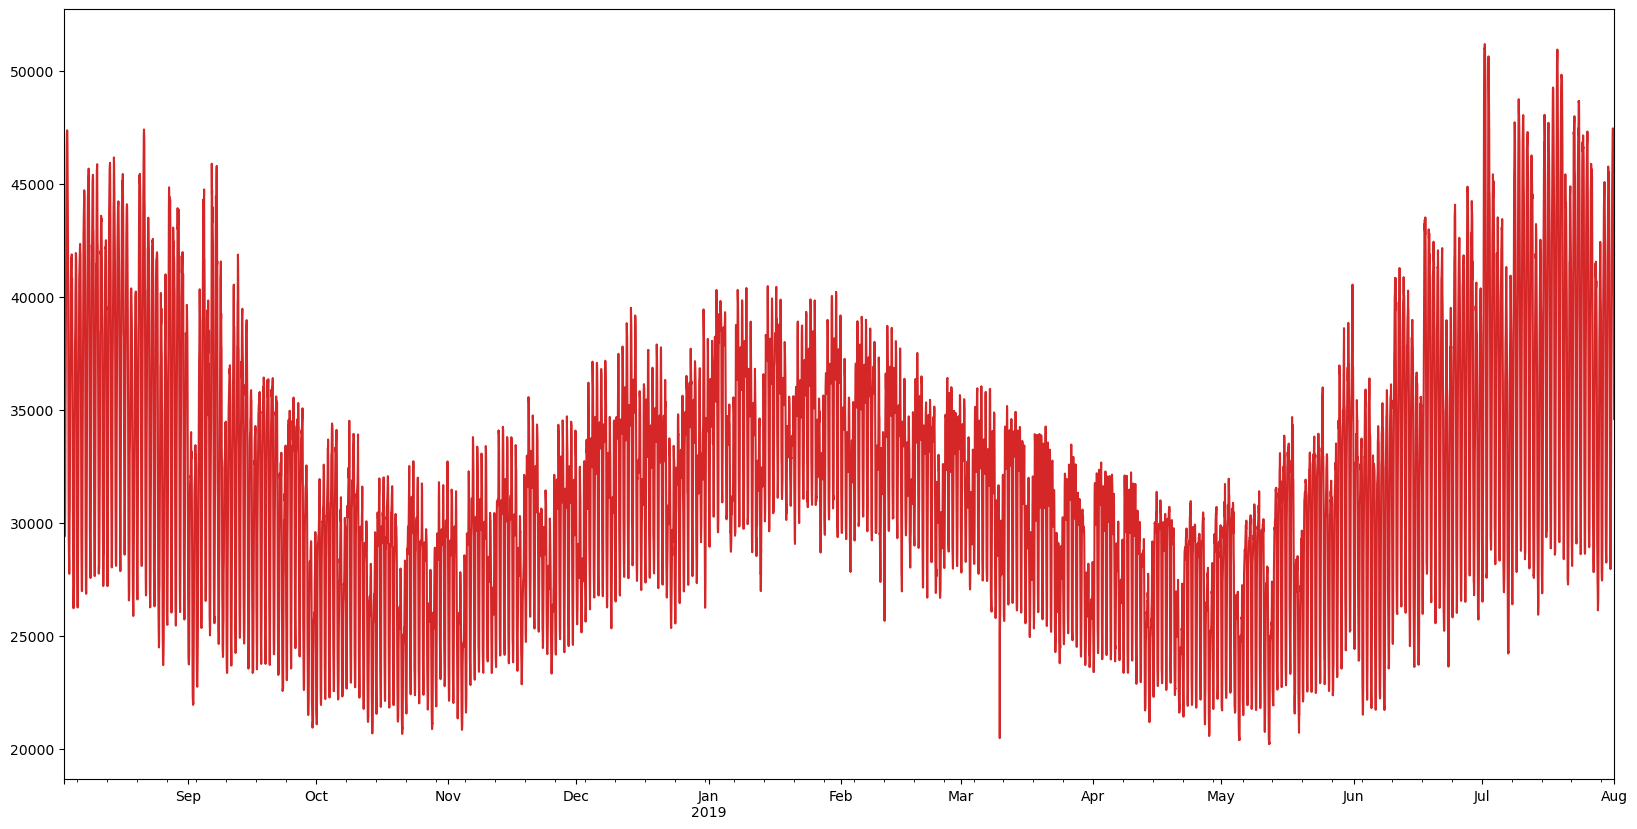

In [349]:
future_w_features['predictions'].plot(
    figsize = (20,10),
    color= color_pal[3]
)

In [311]:
pd.date_range?

Signature:
pd.date_range(
    start=None,
    end=None,
    periods=None,
    freq=None,
    tz=None,
    normalize: 'bool' = False,
    name: 'Hashable | None' = None,
    inclusive: 'IntervalClosedType' = 'both',
    *,
    unit: 'str | None' = None,
    **kwargs,
) -> 'DatetimeIndex'
Docstring:
Return a fixed frequency DatetimeIndex.

Returns the range of equally spaced time points (where the difference between any
two adjacent points is specified by the given frequency) such that they all
satisfy `start <[=] x <[=] end`, where the first one and the last one are, resp.,
the first and last time points in that range that fall on the boundary of ``freq``
(if given as a frequency string) or that are valid for ``freq`` (if given as a
:class:`pandas.tseries.offsets.DateOffset`). (If exactly one of ``start``,
``end``, or ``freq`` is *not* specified, this missing parameter can be computed
given ``periods``, the number of timesteps in the range. See the note below.)

Parameters
----------
st